In [1]:
!wget https://raw.githubusercontent.com/ygtxr1997/CelebBasis/main/infer_images/wiki_names.txt

--2023-09-22 18:51:26--  https://raw.githubusercontent.com/ygtxr1997/CelebBasis/main/infer_images/wiki_names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15886 (16K) [text/plain]
Saving to: ‘wiki_names.txt.2’

wiki_names.txt.2    100%[===================>]  15.51K  --.-KB/s    in 0.005s  

2023-09-22 18:51:26 (2.89 MB/s) - ‘wiki_names.txt.2’ saved [15886/15886]



In [6]:
!wget https://raw.githubusercontent.com/ygtxr1997/CelebBasis/main/infer_images/celebs.txt

--2023-09-22 18:53:17--  https://raw.githubusercontent.com/ygtxr1997/CelebBasis/main/infer_images/celebs.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1528 (1.5K) [text/plain]
Saving to: ‘celebs.txt’

celebs.txt          100%[===================>]   1.49K  --.-KB/s    in 0s      

2023-09-22 18:53:17 (12.9 MB/s) - ‘celebs.txt’ saved [1528/1528]



In [7]:
from pathlib import Path

#with Path('wiki_names.txt.1').open() as f:
with Path('celebs.txt').open() as f:
    wiki_names = f.read().split('\n')

len(wiki_names) # 1109

first_names = list(set([name.split(' ')[0] for name in wiki_names]))
last_names = list(set([name.split(' ')[-1] for name in wiki_names]))
len(first_names), len(last_names)

(109, 111)

In [8]:
first_names[:10] # maybe filter out names with "." in them

['Michael',
 'Brian',
 'Will',
 'Tom',
 'Simon',
 'James',
 'J.K.',
 'Robin',
 'Keanu',
 'Archie']

In [9]:
last_names[:10]

['Limbaugh',
 'Kao',
 'Sheindlin',
 'Bieber',
 'Kingsley',
 'McCartney',
 'Perry',
 'Kardashian',
 'Munchetty',
 'James']

In [1]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionPipeline.from_pretrained(
                model_id,
                revision="fp16",
                #torch_dtype=torch.float16,
                #use_auth_token=True
            )

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/dmarx/.local/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [7]:
pipe.to('cuda')

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.19.0",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [15]:
kwargs = dict(
    num_inference_steps=25,
    num_images_per_prompt=4
)
prompt = "a painting of an apple"
outv = pipe(prompt, **kwargs)

  0%|          | 0/25 [00:00<?, ?it/s]

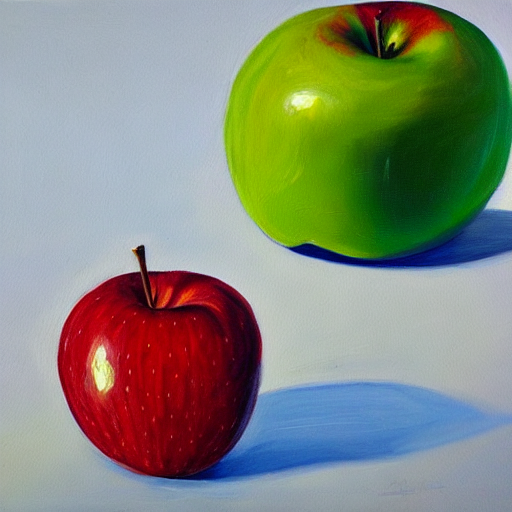

In [16]:
outv.images[0]